In [1]:
from _3DHR_Utilities import *

# Imports only once

In [2]:
# To read the hologram only once

path = "C:/Users/dacv0/Documents/Codigo/Python/avanzado 1/"
grab = read(path +'40X/' + 'holo_ESP_165.bmp')


In [3]:
# DHM parameters, only once
dx, dy = 3.5, 3.5 #um
region = 1 # Depends on the sample
lambda_ = 0.633 #um

In [4]:
# Compensate the image only once
holo = compensate(grab, dx, dy, lambda_, region, step=0.5, depth=3)

#save(holo, 'filtrado', path=path+'resultados/', ext='png')

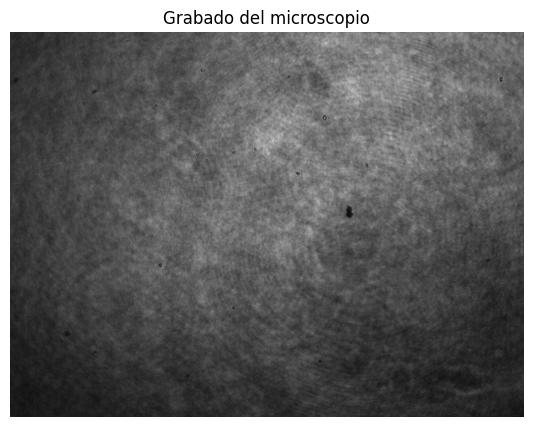

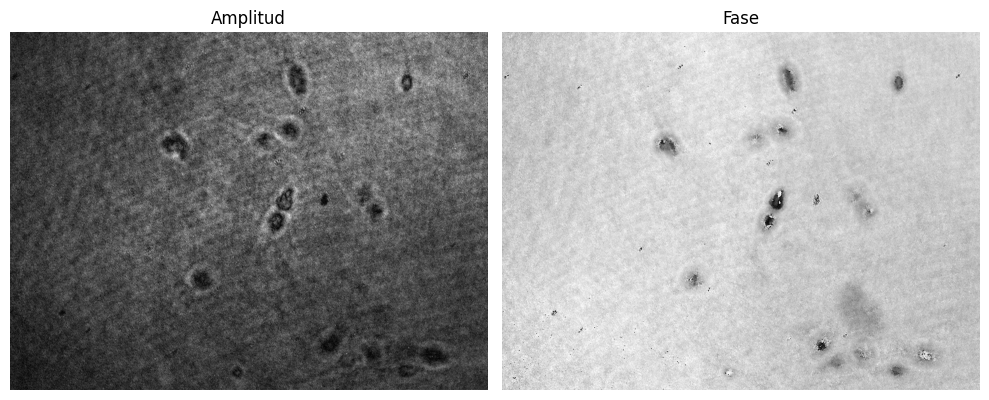

In [67]:
# Show the original and compensated images

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

axes.imshow(np.abs(grab), cmap='gray')
axes.set_title('Grabado del microscopio')
axes.axis('off')


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.abs(holo), cmap='gray')
axes[0].set_title('Amplitud')
axes[0].axis('off')

axes[1].imshow(np.angle(holo), cmap='gray')
axes[1].set_title('Fase')
axes[1].axis('off')
plt.tight_layout()

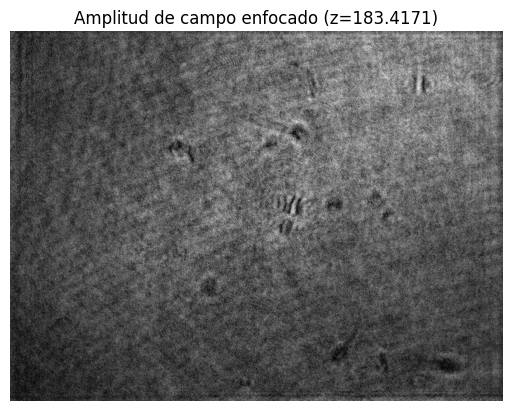

In [68]:
foc, dist, _ = prop_focus(holo, (0, 0), holo.shape, lambda_, dx, dy, -500, 500, 200, 40, metric='combined')

plt.figure()
plt.imshow(np.abs(foc), cmap='gray')
plt.title(f'Amplitud de campo enfocado (z={dist})')
plt.axis('off')
plt.show()

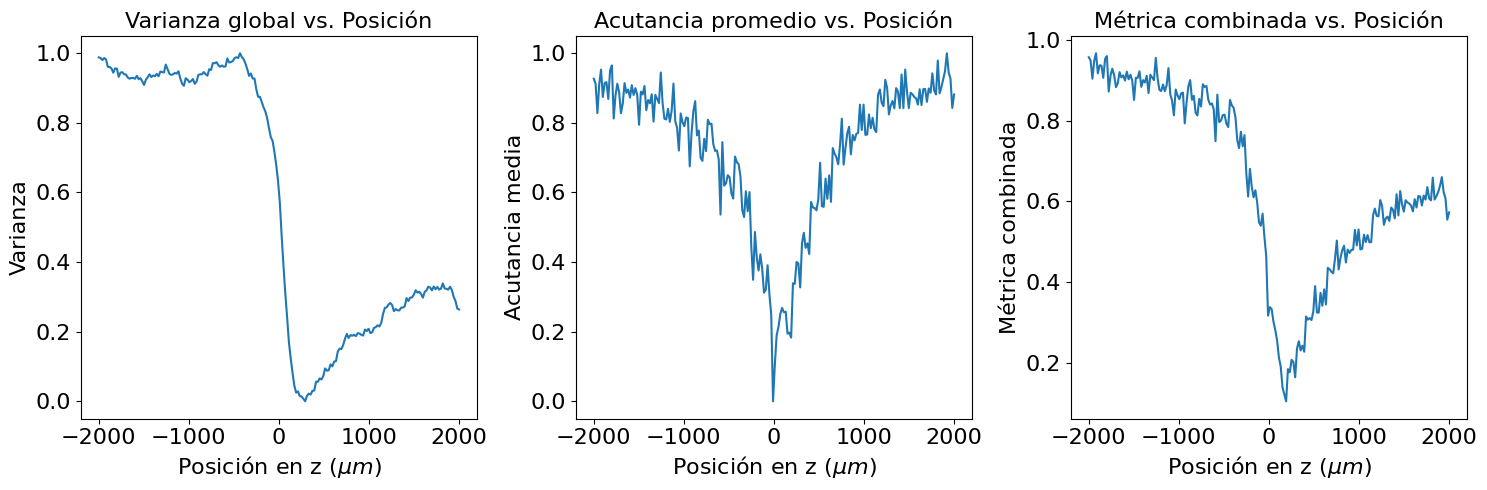

In [6]:
# Show the focus metric for every propagated distance

_, _, variance = prop_focus(holo, [], (), lambda_, dx, dy, -2000, 2000, 200, 40, metric='variance')
_, _, acutance = prop_focus(holo, [], (), lambda_, dx, dy, -2000, 2000, 200, 40, metric='acutance')
_, _, combined = prop_focus(holo, [], (), lambda_, dx, dy, -2000, 2000, 200, 40, metric='combined')
z = np.linspace(-2000, 2000, 200)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

font_size = 16
tick_size = 16


# Primer gráfico
ax1.plot(z, normalize(variance, 1))
ax1.set_title('Varianza global vs. Posición', fontsize=font_size)
ax1.set_xlabel(r'Posición en z ($\mu m$)', fontsize=font_size)
ax1.set_ylabel('Varianza', fontsize=font_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)


# Segundo gráfico
ax2.plot(z, normalize(acutance, 1))
ax2.set_title('Acutancia promedio vs. Posición', fontsize=font_size)
ax2.set_xlabel(r'Posición en z ($\mu m$)', fontsize=font_size)
ax2.set_ylabel('Acutancia media', fontsize=font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)


# Tercer gráfico
ax3.plot(z, combined/2)
ax3.set_title('Métrica combinada vs. Posición', fontsize=font_size)
ax3.set_xlabel(r'Posición en z ($\mu m$)', fontsize=font_size)
ax3.set_ylabel('Métrica combinada', fontsize=font_size)
ax3.tick_params(axis='both', which='major', labelsize=tick_size)


plt.tight_layout()




In [26]:
holo.shape

(960, 1280)

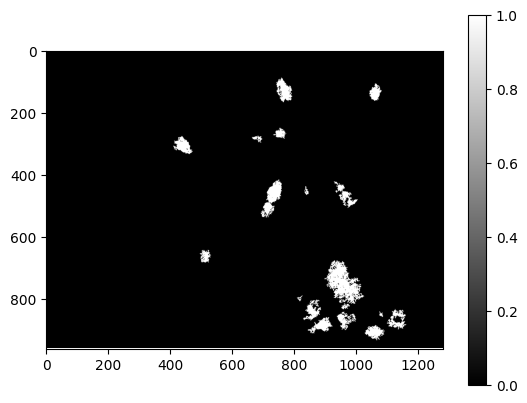

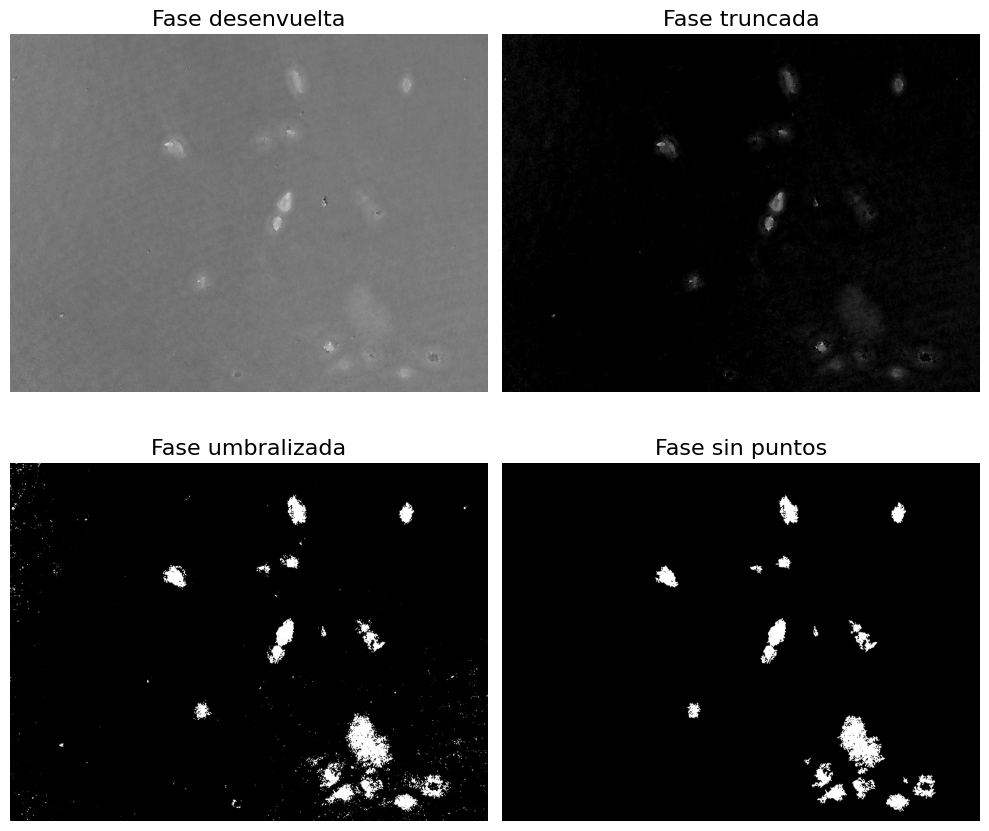

In [24]:
# Show the prepared sample for automatic 3D focus

sample = prepare_sample(holo)

normal = np.ones(holo.shape) - normalize(unwrap_phase(np.angle(holo)), 1)

trunc = normal - np.ones(holo.shape)*np.mean(normal)

filter = trunc < 0
trunc[filter] = 0

threshold = threshold_otsu(trunc)
th = trunc>threshold

th_cleaned = morphology.remove_small_objects(th, min_size=100)

plt.figure()
plt.imshow(th_cleaned, cmap='gray')
plt.colorbar()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9))

font_size = 16
tick_size = 16


# Primer gráfico
ax1.imshow(normal, cmap='gray')
ax1.set_title('Fase desenvuelta', fontsize=font_size)
ax1.axis('off')

# Segundo gráfico
ax2.imshow(trunc, cmap='gray')
ax2.set_title('Fase truncada', fontsize=font_size)
ax2.axis('off')



# Tercer gráfico
ax3.imshow(th, cmap='gray')
ax3.set_title('Fase umbralizada', fontsize=font_size)
ax3.axis('off')


ax4.imshow(th_cleaned, cmap='gray')
ax4.set_title('Fase sin puntos', fontsize=font_size)
ax4.axis('off')

plt.tight_layout()


Text(0.5, 1.0, 'Kmeans clustering')

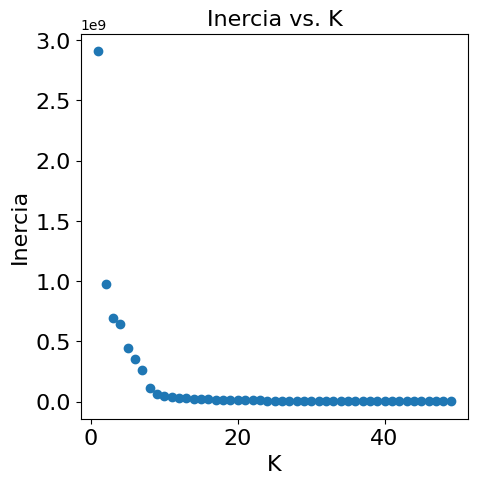

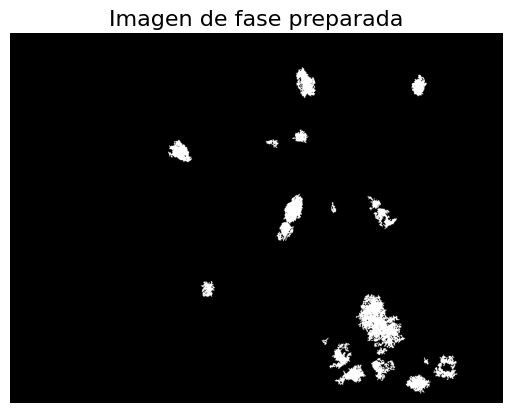

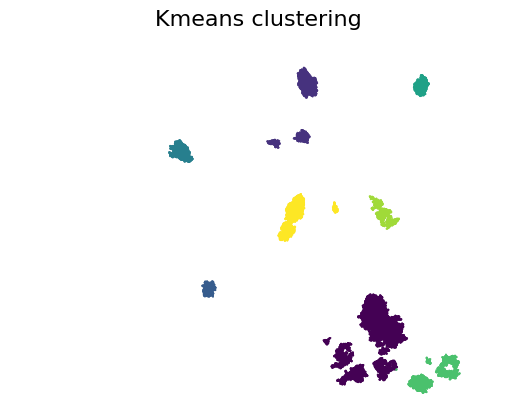

In [70]:
# Performs clustering algorithm and shows all relevant information

BW, vals, clust = cluster(holo, show_elbow_graph=True)

fig, axes = plt.subplots(1, 1)
axes.imshow(BW, cmap='gray')
axes.set_title('Imagen de fase preparada', fontsize=16)
axes.axis('off')
# axes.set_xlabel('Píxel', fontsize=16)
# axes.set_ylabel('Píxel', fontsize=16)
# axes.tick_params(axis='both', which='major', labelsize=16)




fig, axes = plt.subplots(1, 1)
axes.scatter(vals[:, 1], vals[:, 0], c=clust.labels_, s=0.1)
axes.set_xlim([0, holo.shape[1]])
axes.set_ylim([0, holo.shape[0]])
axes.axis('off')

plt.gca().invert_yaxis()

axes.set_title('Kmeans clustering', fontsize=16)

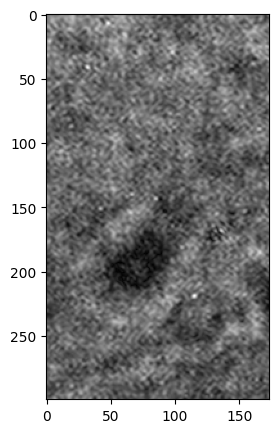

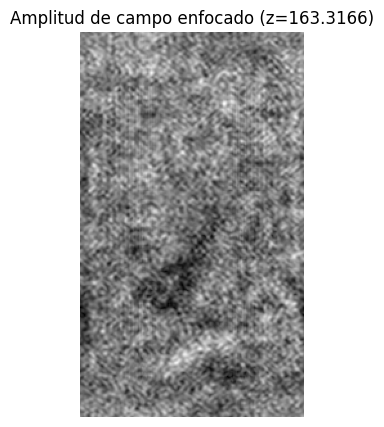

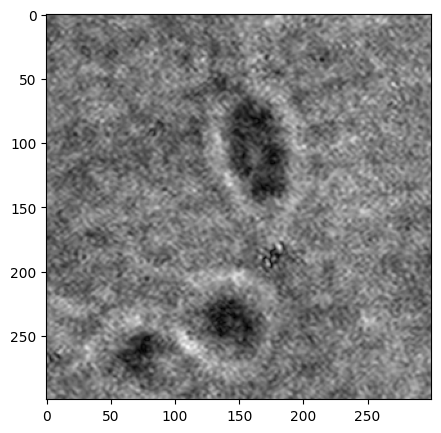

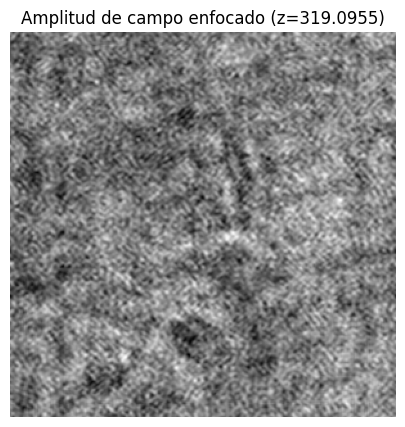

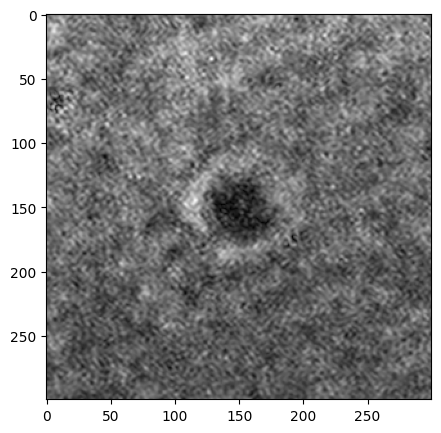

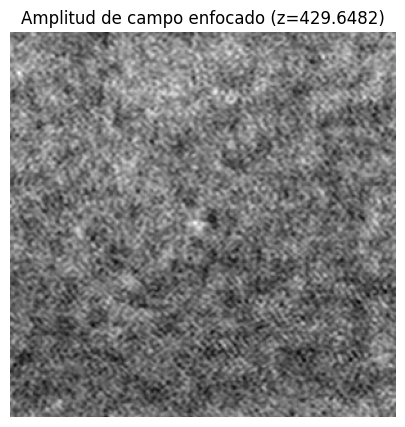

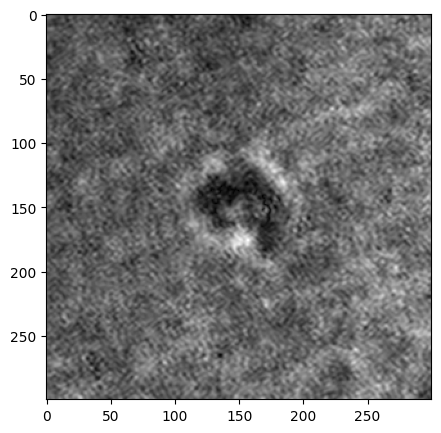

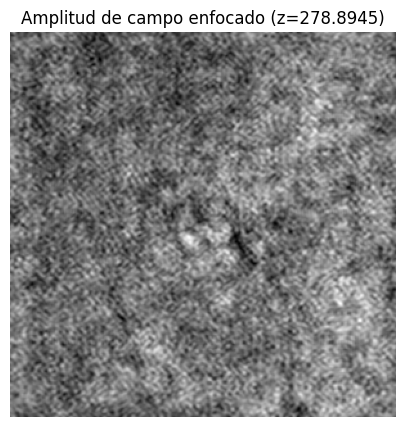

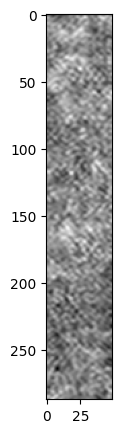

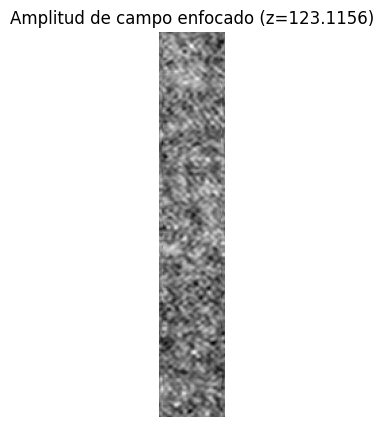

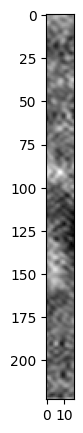

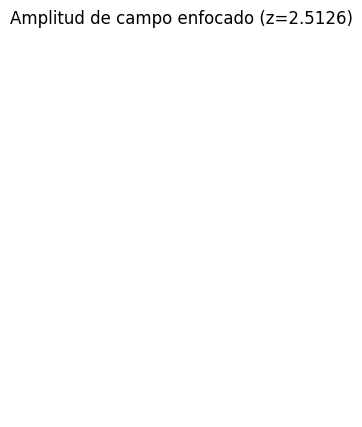

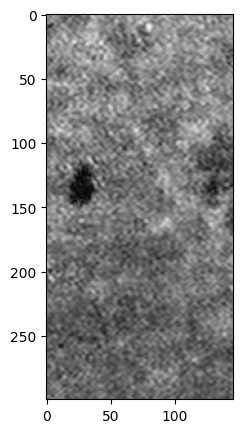

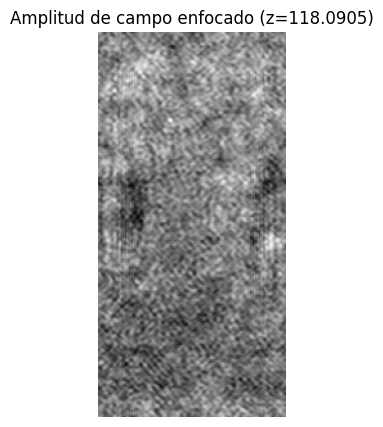

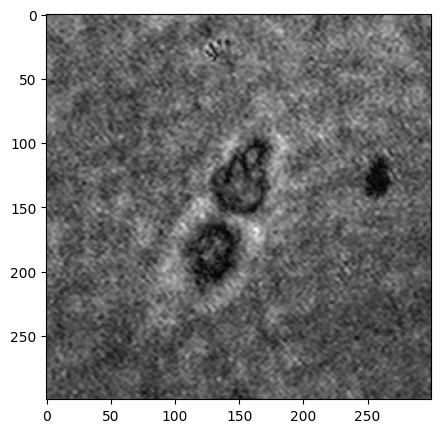

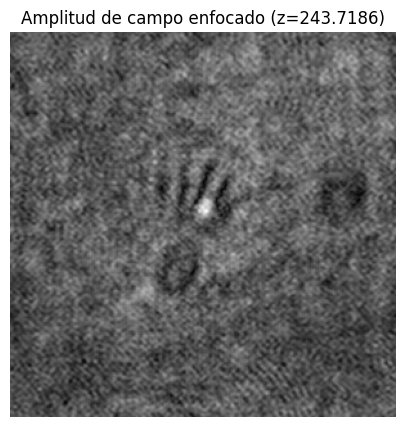

[793.1140544518092, 175.12237037038227, 664.3352402746, 307.77434805748777, 137.18794048552382, 887.1886630403717, 468.50878186968487, 474.6315930388228] [936.6032376747592, 756.4613333333307, 513.12700228833, 441.32251197444816, 1061.2129992169107, 1094.940166046382, 964.3569405099133, 734.4048192771089] [163.3166, 319.0955, 429.6482, 278.8945, 123.1156, 2.5126, 118.0905, 243.7186]


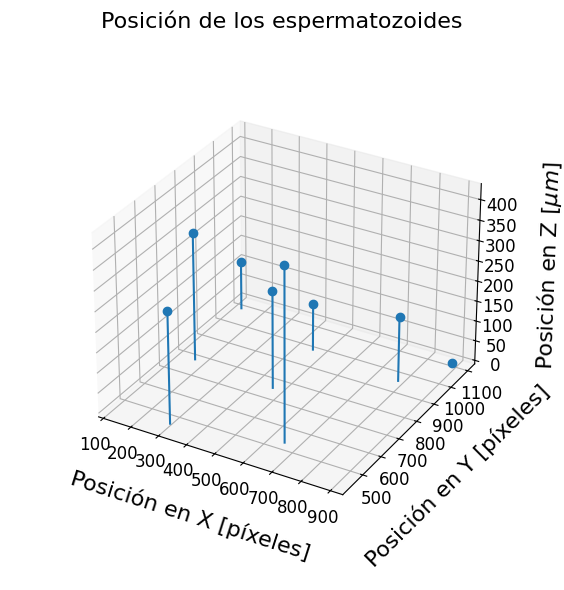

In [60]:
sub = window_extraction(holo, clust.cluster_centers_, (300, 300), rimpercent=(0.8, 0.8))


posx = []
posy = []
posz = []


prop = []


for i in range(len(clust.cluster_centers_)):
  fig, axes = plt.subplots(1, 1, figsize=(10, 5))
  axes.imshow(np.abs(sub[i]), cmap='gray')
  plt.show()
  prop_foc, distances, metrics = prop_focus(sub[i], clust.cluster_centers_[i], (300, 300), lambda_, dx, dy, -500, 500, 200, 40, 1)
  prop.append(prop_foc)

  try:
    #The range of propagation here is hardcoded
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    axes.imshow(np.abs(prop_foc), cmap='gray')
    axes.set_title(f'Amplitud de campo enfocado (z={distances})')
    plt.axis('off')
    plt.show()

  except:
    print('skipped')
    continue

  posx.append(clust.cluster_centers_[i][0])
  posy.append(clust.cluster_centers_[i][1])
  posz.append(distances)


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

print(posx, posy, posz)
markerline, stemlines, baseline = ax.stem(posx, posy, posz)
plt.title("Posición de los espermatozoides", fontsize=font_size)
ax.set_xlabel('Posición en X [píxeles]', fontsize=font_size) 
ax.set_ylabel('Posición en Y [píxeles]', fontsize=font_size) 
ax.set_zlabel(r'Posición en Z [$\mu m$]', fontsize=font_size)
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.3, 
        alpha = 0.2) 
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18
plt.tight_layout()

plt.setp(baseline, visible=False)
plt.show()



8


(-0.5, 299.5, 299.5, -0.5)

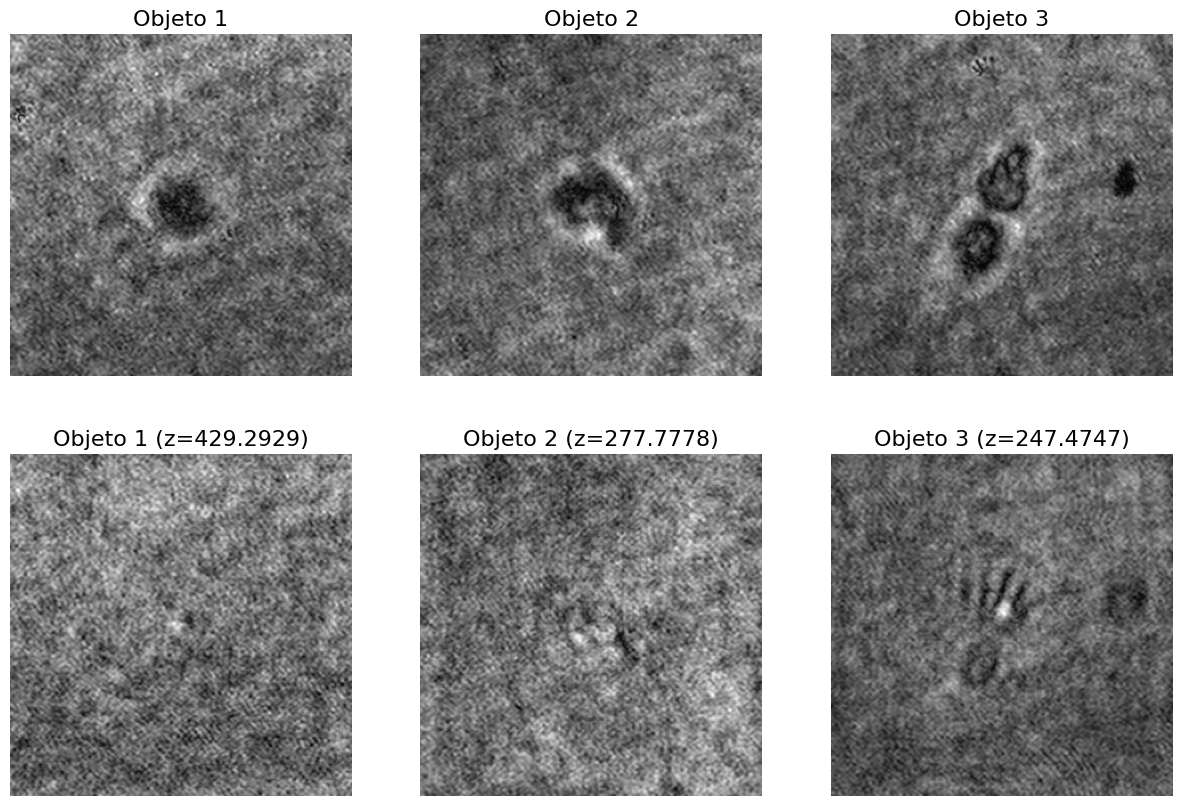

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

font_size = 16
tick_size = 16


# Primer gráfico
axes[0, 0].imshow(np.abs(sub[2]), cmap='gray')
axes[0, 0].set_title('Objeto 1', fontsize=font_size)
axes[0, 0].axis('off')

# Segundo gráfico
axes[0, 1].imshow(np.abs(sub[3]), cmap='gray')
axes[0, 1].set_title('Objeto 2', fontsize=font_size)
axes[0, 1].axis('off')

print(len(prop))
# Tercer gráfico
axes[0, 2].imshow(np.abs(sub[-1]), cmap='gray')
axes[0, 2].set_title('Objeto 3', fontsize=font_size)
axes[0, 2].axis('off')


axes[1, 0].imshow(np.abs(prop[2]), cmap='gray')
axes[1, 0].set_title(f'Objeto 1 (z={posz[2]})', fontsize=font_size)
axes[1, 0].axis('off')

axes[1, 1].imshow(np.abs(prop[3]), cmap='gray')
axes[1, 1].set_title(f'Objeto 2 (z={posz[3]})', fontsize=font_size)
axes[1, 1].axis('off')

axes[1, 2].imshow(np.abs(prop[-1]), cmap='gray')
axes[1, 2].set_title(f'Objeto 3 (z={posz[-1]})', fontsize=font_size)
axes[1, 2].axis('off')

